In [7]:
import numpy as np
import pandas as pd
from scipy import stats
from dateutil import parser
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics
from collections import defaultdict
import json
import datetime
import time
import datetime as dt

DATA_PATH = '../processed_data/'

all_data = pd.read_csv(DATA_PATH + 'allDataCombined.csv')
price_data = pd.read_csv(DATA_PATH + 'priceData.csv')
df = pd.merge(all_data, price_data, on="timestamp")
df['date'] = df['timestamp'].apply(lambda x: parser.parse(x).date())
df['time'] = df['timestamp'].apply(lambda x: parser.parse(x).strftime("%H:%M:%S"))
corr = []
corr_all = []
pnl = defaultdict(list)
index = 0

df['NOPE'] = df['NOPE_busVolume'] * 100

#for short testing, remove feb 19 2020 to march 23 2020
temp1 = df[df['date'] < datetime.date(2020, 2, 19)] 
temp2 = df[df['date'] > datetime.date(2020, 3, 23)] 
dfshort = pd.concat([temp1, temp2], axis=0)
dfshort = dfshort.reset_index(drop=True)
#add time column in datetime
dfshort['timeDT'] = pd.to_datetime(dfshort['time'])

def backtest_short(day_group, start_time, stop_time, short_entry):
    drawdown_values = []
    entry_price = 0
    exit_price = 0
    exit_index = 0
    max_drawdown = 0
    total_pnl = 0
    win_count = 0
    loss_count = 0
    
    i = 0
    rowlimit = len(day_group)
    #loop through rows in a day
    while i < rowlimit:
        if day_group['NOPE'][i] >= short_entry and day_group['time'][i] > start_time and day_group['time'][i] < stop_time:
            entry_price = day_group['active_underlying_price'][i]
            #check that there is a NOPE < 15 in the rest of the day
            if day_group['NOPE'][i:].lt(15).sum() > 0:
                #find the location of the exit, first location where NOPE < 15
                exit_index = day_group['NOPE'][i:].lt(15).idxmax() #in a true/false array, idxmax() returns the first True
                exit_price = day_group['active_underlying_price'][exit_index]
                #find max drawdown
                #drawdown_values.append(day_group['active_underlying_price'][i:exit_index].max())
                #find profit
                total_pnl = total_pnl + (entry_price - exit_price)
                #increment win counter
                if exit_price < entry_price:
                    win_count = win_count + 1
                else:
                    loss_count = loss_count + 1
                #skip index to end of the block
                i = exit_index
            else:
                i = len(day_group)
                #losing trade, calculate loss
                exit_price = day_group['active_underlying_price'][i-1]
                total_pnl = total_pnl + (entry_price - exit_price)
                #increment loss counter
                loss_count = loss_count + 1
        i = i + 1
    return [total_pnl, win_count, loss_count]





days = []
for name, group in dfshort.groupby('date'):
    days.append(group)

for i in range(0, len(days)):
    days[i] = days[i].reset_index(drop=True)


stop_times = ['12:00:00', '12:10:00', '12:20:00', '12:30:00', '12:40:00', '12:50:00', '13:00:00', '13:10:00', '13:20:00', '13:30:00', '13:40:00', '13:50:00', '14:00:00', '14:10:00', '14:20:00', '14:30:00', '14:40:00', '14:50:00', '15:00:00', '15:10:00', '15:20:00', '15:30:00', '15:40:00', '15:50:00', '16:00:00']
wins = []
loss = []
ratio = []

t0 = time.time()
for i, stoptime in enumerate(stop_times):
    real_total_pnl = 0
    total_wins = 0
    total_loss = 0
    for i, elem in enumerate(days):
        temp = backtest_short(elem, '10:15:00', stoptime, 30)
        real_total_pnl = real_total_pnl + temp[0]
        total_wins = total_wins + temp[1]
        total_loss = total_loss + temp[2]
    wins.append(total_wins)
    loss.append(total_loss)
    ratio.append(total_wins / (total_loss + total_wins) * 100)
    print(str(total_wins) + ', ' + str(total_loss))
    
t1 = time.time()
print(t1 - t0)
print(real_total_pnl)
print(ratio)


65, 21
68, 22
71, 22
75, 22
78, 24
79, 26
81, 28
83, 29
90, 30
95, 31
97, 32
101, 34
103, 35
109, 39
112, 42
117, 45
119, 46
122, 47
125, 49
133, 54
135, 58
140, 60
144, 62
146, 67
149, 73
2.668548107147217
39.396999999999935
[75.5813953488372, 75.55555555555556, 76.34408602150538, 77.31958762886599, 76.47058823529412, 75.23809523809524, 74.31192660550458, 74.10714285714286, 75.0, 75.39682539682539, 75.1937984496124, 74.81481481481481, 74.63768115942028, 73.64864864864865, 72.72727272727273, 72.22222222222221, 72.12121212121212, 72.18934911242604, 71.83908045977012, 71.12299465240642, 69.94818652849742, 70.0, 69.90291262135922, 68.54460093896714, 67.11711711711712]


Text(0.5, 0, 'entrance cutoff time')

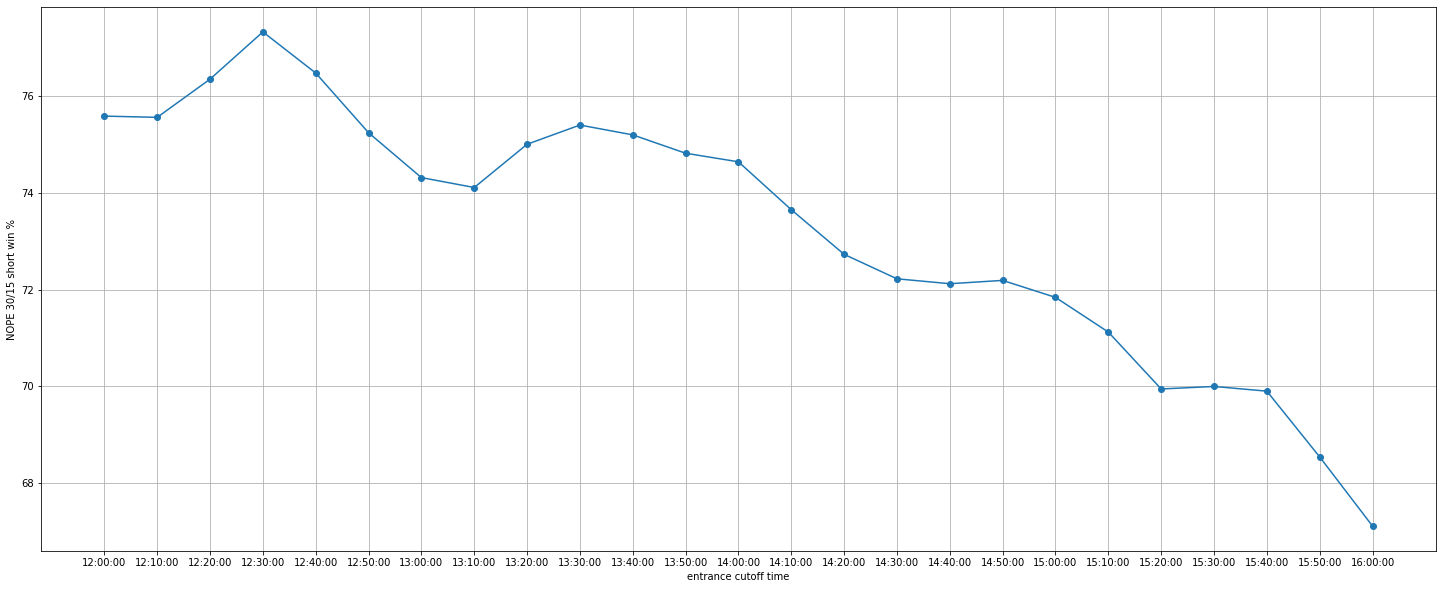

In [6]:
plt.figure(figsize=(25,10))
plt.plot(stop_times, ratio, 'o-')
plt.grid()
plt.ylabel('NOPE 30/15 short win %')
plt.xlabel('entrance cutoff time')